## Load Data

In [1]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
import torch.nn as nn
import torch.optim as optim

import conformal.cp_lib as cp
import conformal.smoothers as sm 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor


folder = "./results"

holdout_results = torch.load(folder + "/holdout_predictions.pth", weights_only=False)
val_results = torch.load(folder + "/val_predictions.pth", weights_only=False)

cal_labels = holdout_results["labels"]
cal_outputs = holdout_results["outputs"]
cal_embeddings = holdout_results["latents"]

val_outputs = val_results["outputs"]
val_labels = val_results["labels"]
val_embeddings = val_results["latents"]

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


### Define head model, final layer of trained model

In [ ]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)

# Load weights
state =torch.load(folder + '/cifar10_resnet18.pth', weights_only=True, map_location='cpu')
model.load_state_dict(state)

model.eval()
head = model.fc

# Create head model adapter for competibility between PyTorch model and sklearn setup
head_model_adapter = cp.TorchAdapter(
    model=head, 
    classes=labels, 
    device='cuda' if torch.cuda.is_available() else 'cpu' # Use GPU if available
)

# Define feature extractors for the smoother if logits or softmax probabilities are to be used
logit_extractor = lambda X: head_model_adapter.predict_logits(X)
softmax_extractor = lambda X: head_model_adapter.predict_proba(X)

In [3]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=3)),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets()

print("DAPS Metrics on Validation Set with KMeans smoother:")
print(daps_metrics)

DAPS Metrics on Validation Set with KMeans smoother:
{'Coverage': np.float64(0.9471), 'Avg Set Size': np.float64(1.2193), 'Singleton Rate': np.float64(0.8409), 'Singleton Hit': np.float64(0.9599238910690926)}


In [4]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=3)),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=logit_extractor)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets()

print("DAPS Metrics on Validation Set with KMeans smoother (using logits as features):")
print(daps_metrics)

DAPS Metrics on Validation Set with KMeans smoother (using logits as features):
{'Coverage': np.float64(0.9465), 'Avg Set Size': np.float64(1.2136), 'Singleton Rate': np.float64(0.8434), 'Singleton Hit': np.float64(0.9602798197770928)}


In [5]:
my_smoother = sm.ClusterSmoother(smoothing_pipeline, feature_extractor=softmax_extractor)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets()

print("DAPS Metrics on Validation Set with KMeans smoother (using softmax probabilities as features):")
print(daps_metrics)

DAPS Metrics on Validation Set with KMeans smoother (using softmax probabilities as features):
{'Coverage': np.float64(0.947), 'Avg Set Size': np.float64(1.2192), 'Singleton Rate': np.float64(0.8425), 'Singleton Hit': np.float64(0.9597626112759644)}


# Try out possible conformal prediction options

In [92]:
tps = cp.TPS(head_model_adapter)
tps.fit(cal_embeddings, cal_labels)
tps_mask = tps.predict(val_embeddings)
sets = tps.convert_to_sets(labels)

tps_metrics = cp.ConformalMetrics(tps_mask, val_labels)
print("TPS Metrics:", tps_metrics)

TPS Metrics: {'Coverage': np.float64(0.9067), 'Avg Set Size': np.float64(1.0158), 'Singleton Rate': np.float64(0.9768), 'Singleton Hit': np.float64(0.9102170352170352)}


In [93]:
aps = cp.RAPS(head_model_adapter, lam_reg = 0, k_reg = 0)
aps.fit(cal_embeddings, cal_labels)
aps_mask = aps.predict(val_embeddings)
sets = aps.convert_to_sets(labels)
aps_metrics = cp.ConformalMetrics(aps_mask, val_labels)
print("APS Metrics:", aps_metrics)

APS Metrics: {'Coverage': np.float64(0.9466), 'Avg Set Size': np.float64(1.2215), 'Singleton Rate': np.float64(0.8445), 'Singleton Hit': np.float64(0.9595026642984015)}


In [100]:
raps = cp.RAPS(head_model_adapter, lam_reg=2, k_reg = 0)
raps.fit(cal_embeddings, cal_labels)
raps_mask = raps.predict(val_embeddings)
sets = raps.convert_to_sets(labels)
raps_metrics = cp.ConformalMetrics(raps_mask, val_labels)
print("RAPS Metrics:", raps_metrics)

RAPS Metrics: {'Coverage': np.float64(0.9052), 'Avg Set Size': np.float64(1.0379), 'Singleton Rate': np.float64(0.9621), 'Singleton Hit': np.float64(0.9085334164847729)}


In [95]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=3)),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets()

print("DAPS Metrics on Validation Set with KMeans smoother:")
print(daps_metrics)

DAPS Metrics on Validation Set with KMeans smoother:
{'Coverage': np.float64(0.9445), 'Avg Set Size': np.float64(1.2064), 'Singleton Rate': np.float64(0.8491), 'Singleton Hit': np.float64(0.9579554822753503)}


In [ ]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=3)),
    ('dtc', DecisionTreeClassifier(max_depth=5, random_state=42))
])

my_smoother = sm.ClusterSmoother(smoothing_pipeline)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets()

print("DAPS Metrics on Validation Set with Decision Tree smoother:")
print(daps_metrics)

DAPS Metrics on Validation Set with Decision Tree smoother:
{'Coverage': np.float64(0.9077), 'Avg Set Size': np.float64(1.0342), 'Singleton Rate': np.float64(0.9658), 'Singleton Hit': np.float64(0.9117829778422033)}


In [97]:
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=8)),
    ('knn', KNeighborsRegressor(n_neighbors=10, metric='euclidean'))
])

my_smoother = sm.KNNSmoother(smoothing_pipeline)

daps = cp.DAPS(head_model=head_model_adapter, smoother=my_smoother)
daps.fit(cal_embeddings, cal_labels)
daps_mask = daps.predict(val_embeddings)
daps_metrics = cp.ConformalMetrics(daps_mask, val_labels)
daps_sets = daps.convert_to_sets(labels)

print("DAPS Metrics on Validation Set with KNN smoother:")
print(daps_metrics)

DAPS Metrics on Validation Set with KNN smoother:
{'Coverage': np.float64(0.9503), 'Avg Set Size': np.float64(1.2758), 'Singleton Rate': np.float64(0.8075), 'Singleton Hit': np.float64(0.9602476780185758)}


# Optimize hyperparameters

In [99]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def cp_efficiency_scorer(y_true, y_pred_sets, target_alpha=0.1):
    """
    Custom scoring function for Conformal Prediction.
    Goal: Minimize Average Set Size, BUT penalize heavily if Coverage is violated.
    """
    # 1. Calculate Empirical Coverage
    n = len(y_true)
    covered = y_pred_sets[np.arange(n), y_true]
    coverage = np.mean(covered)
    
    # 2. Calculate Average Set Size
    set_sizes = np.sum(y_pred_sets, axis=1)
    avg_size = np.mean(set_sizes)
    
    # 3. The Penalty Logic
    # We allow a tiny bit of slack (e.g., 0.02) because CV datasets are small 
    # and noise might drop coverage to 89% even if the model is good.
    required_coverage = (1 - target_alpha) - 0.02
    
    if coverage < required_coverage:
        # If coverage is bad, return a terrible score. 
        # We weigh it by how bad the coverage is.
        return -1000 + (coverage * 100) 
    else:
        # If coverage is good, we want the smallest set size.
        # Since GridSearchCV MAXIMIZES, we return NEGATIVE size.
        return -avg_size

# 1. Create the Scorer Object
cp_scorer = make_scorer(
    cp_efficiency_scorer, 
    greater_is_better=True, 
    response_method="predict",  # <--- NEW SYNTAX (Replaces needs_threshold/needs_proba)
    target_alpha=0.1            # Pass your extra args here
)

# 2. Define Parameter Grid
# Let's tune RAPS to find the best regularization
param_grid = {
    'lam_reg': [0.0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 9, 12, 15, 17, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 150, 200],  # Regularization weight
    'k_reg': [0, 1, 2, 3, 4, 5]                   # cutoff for regularization
}

# 3. Initialize Model
raps = cp.RAPS(head_model_adapter, alpha=0.1)

# 4. Setup Grid Search
# cv=5 means it internally splits X_cal into 5 folds
grid = GridSearchCV(
    estimator=raps,
    param_grid=param_grid,
    scoring=cp_scorer,
    cv=5, 
    verbose=1
)

print("Tuning Hyperparameters on Calibration Data...")
# IMPORTANT: We pass CALIBRATION data here. 
# The 'CV' splits this into internal cal/val sets.
grid.fit(cal_embeddings, cal_labels) 

# 5. Results
print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best Score (Neg Set Size): {grid.best_score_:.4f}")


Tuning Hyperparameters on Calibration Data...
Fitting 5 folds for each of 174 candidates, totalling 870 fits

Best Parameters: {'k_reg': 0, 'lam_reg': 2}
Best Score (Neg Set Size): -1.0377


In [101]:
# Tune DAPS Hyperparameters
cp_scorer = make_scorer(
    cp_efficiency_scorer, 
    greater_is_better=True, 
    response_method="predict",  # <--- NEW SYNTAX (Replaces needs_threshold/needs_proba)
    target_alpha=0.1            # Pass your extra args here
)

# 2. Define Parameter Grid
# Let's tune RAPS to find the best regularization
param_grid = {
    'lam_reg': [0.0, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5],  # Regularization weight
    'k_reg': [0, 1, 2, 3, 4, 5],                   # cutoff for regularization
    'beta' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# 3. Initialize Model
smoothing_pipeline = Pipeline([
    ('pca', PCA(n_components=3)),
    ('dtc', DecisionTreeClassifier(max_depth=5, random_state=42))
])
my_smoother = sm.ClusterSmoother(smoothing_pipeline)
daps = cp.DAPS(head_model_adapter, my_smoother, alpha=0.1)

# 4. Setup Grid Search
# cv=5 means it internally splits X_cal into 5 folds
grid = GridSearchCV(
    estimator=daps,
    param_grid=param_grid,
    scoring=cp_scorer,
    cv=5, 
    verbose=1
)

print("Tuning Hyperparameters on Calibration Data...")
# IMPORTANT: We pass CALIBRATION data here. 
# The 'CV' splits this into internal cal/val sets.
grid.fit(cal_embeddings, cal_labels) 

# 5. Results
print(f"\nBest Parameters: {grid.best_params_}")
print(f"Best Score (Neg Set Size): {grid.best_score_:.4f}")


Tuning Hyperparameters on Calibration Data...
Fitting 5 folds for each of 726 candidates, totalling 3630 fits

Best Parameters: {'beta': 0, 'k_reg': 1, 'lam_reg': 1.5}
Best Score (Neg Set Size): -1.0349


## Plot results

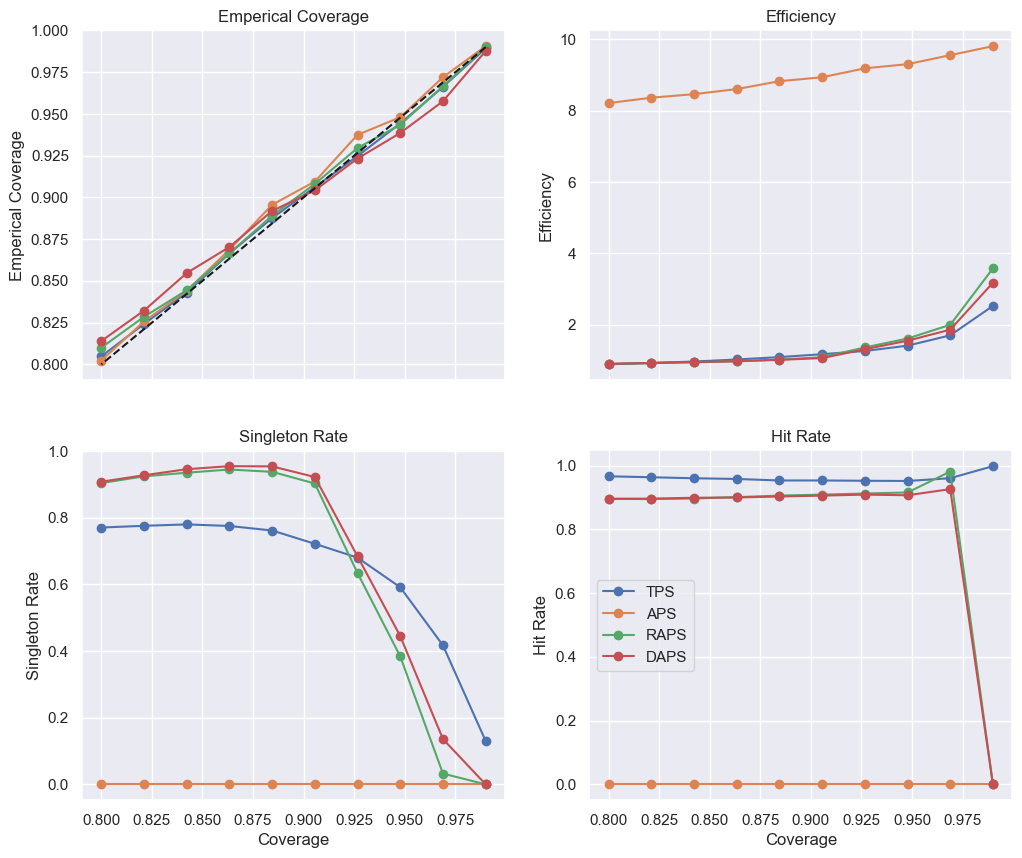

In [13]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Plot emperical coverage, avg set size, singleton rate and hit rate of the different models agains alpha levels
alphas = np.linspace(0.01, 0.2, 10)
models = {
    "TPS": cp.TPS(),
    "APS": cp.RAPS(lam_reg=0, k_reg=0),
    "RAPS": cp.RAPS(lam_reg=60, k_reg=0),
    "DAPS": cp.DAPS(lam_reg=60, k_reg=0, beta=0.2)
}
results = {name: {"Emperical coverage": [], "Efficiency": [], "singleton_rate": [], "hit_rate": []} for name in models.keys()}

for alpha in alphas:
    for name, model in models.items():
        model.alpha = alpha
        model.fit(cal_outputs, cal_labels) if name != "DAPS" else model.fit(cal_outputs, cal_labels, cal_cluster_ids)
        preds = model.predict(val_outputs) if name != "DAPS" else model.predict(val_outputs, val_cluster_ids)
        metrics = cp.ConformalMetrics(preds, val_labels)
        results[name]["Emperical coverage"].append(metrics["Coverage"])
        results[name]["Efficiency"].append(metrics["Avg Set Size"])
        results[name]["singleton_rate"].append(metrics["Singleton Rate"])
        results[name]["hit_rate"].append(metrics["Singleton Hit"])


fig, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
for i, metric in enumerate(["Emperical coverage", "Efficiency", "singleton_rate", "hit_rate"]):
    for name in models.keys():
        ax[i//2, i % 2].plot(1-alphas, results[name][metric], label=name, marker='o')
    if metric == "Emperical coverage":
        ax[i//2, i % 2].plot(1-alphas, 1 - alphas, 'k--', label="Ideal Coverage")
    if i >= 2:
        ax[i//2, i % 2].set_xlabel("Coverage")
    ax[i//2, i % 2].set_ylabel(metric.replace("_", " ").title())
    ax[i//2, i % 2].set_title(f"{metric.replace('_', ' ').title()}")
plt.legend()
plt.show()


## Tune RAPS

### Tune DAPS

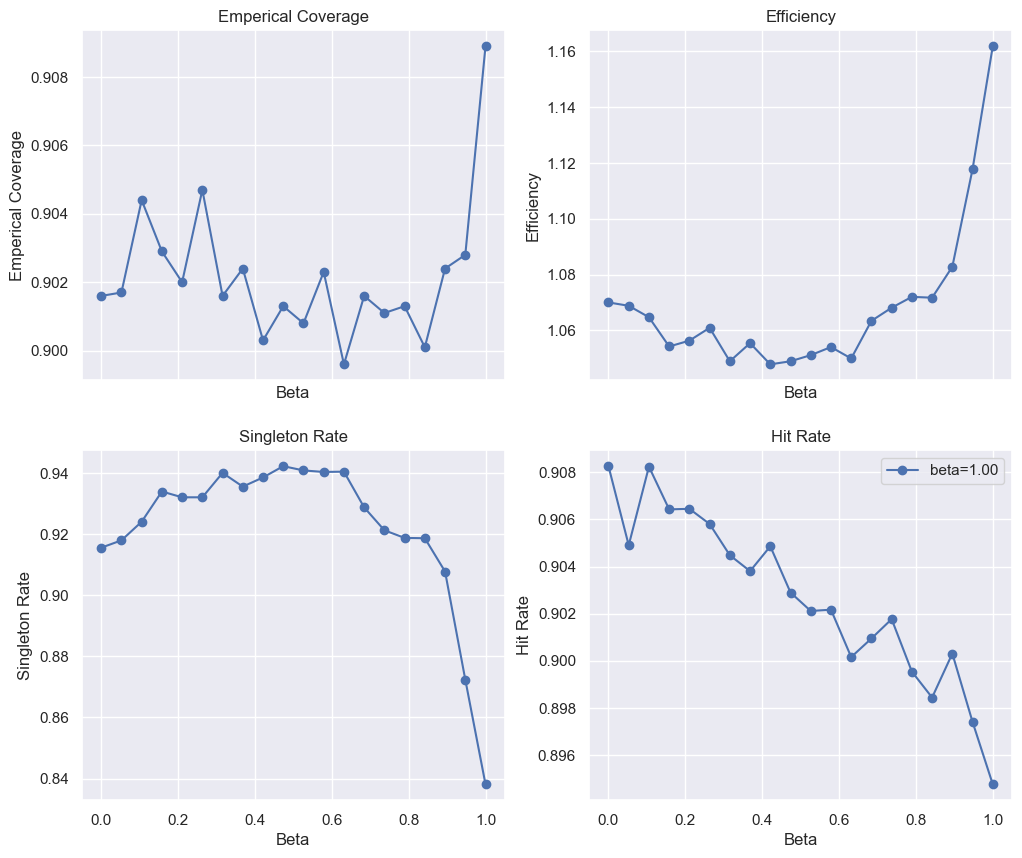

In [15]:
daps = cp.DAPS(lam_reg=60, k_reg=0, beta=0.1)

betas = np.linspace(0, 1, 20)
results = {"Emperical coverage": [], "Efficiency": [], "singleton_rate": [], "hit_rate": []}

for beta in betas:
    daps.beta = beta
    daps.fit(cal_outputs, cal_labels, cal_cluster_ids)
    preds = daps.predict(val_outputs, val_cluster_ids)
    metrics = cp.ConformalMetrics(preds, val_labels)
    results["Emperical coverage"].append(metrics["Coverage"])
    results["Efficiency"].append(metrics["Avg Set Size"])
    results["singleton_rate"].append(metrics["Singleton Rate"])
    results["hit_rate"].append(metrics["Singleton Hit"])


fig, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
for i, metric in enumerate(["Emperical coverage", "Efficiency", "singleton_rate", "hit_rate"]):
    ax[i//2, i % 2].plot(betas, results[metric], label=f"beta={beta:.2f}", marker='o')
    ax[i//2, i % 2].set_xlabel("Beta")
    ax[i//2, i % 2].set_ylabel(metric.replace("_", " ").title())
    ax[i//2, i % 2].set_title(f"{metric.replace('_', ' ').title()}")

plt.legend()
plt.show()

### DAPS metrics for different clustering methods

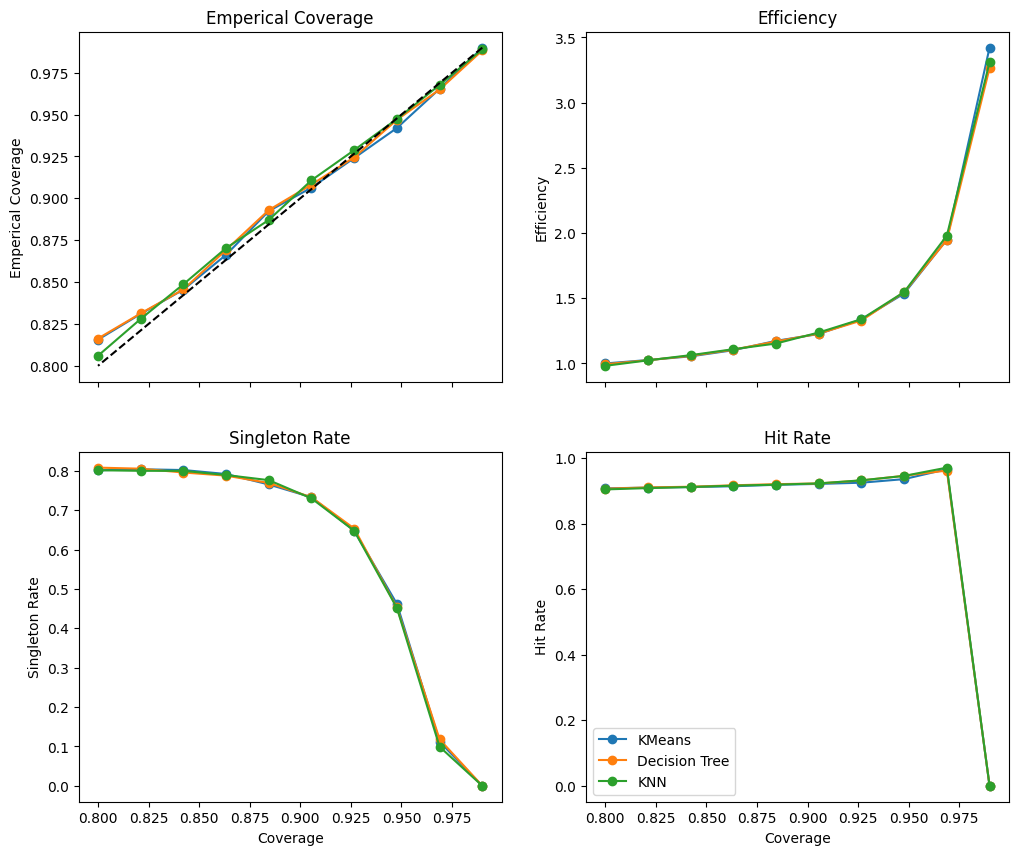

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on calibration and validation outputs
pca = PCA(n_components=10)
cal_outputs_pca = pca.fit_transform(cal_outputs)
val_outputs_pca = pca.transform(val_outputs)

# Fit and predict using KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(cal_outputs_pca)
cal_cluster_ids_kmeans = kmeans.predict(cal_outputs_pca)
val_cluster_ids_kmeans = kmeans.predict(val_outputs_pca)

# Fit and predict using Decision Tree
dtc = DecisionTreeClassifier(random_state=0).fit(cal_outputs_pca, cal_labels)
cal_cluster_ids_dtc = dtc.predict(cal_outputs_pca)
val_cluster_ids_dtc = dtc.predict(val_outputs_pca)

# Fit and predict using KNN
knn = KNeighborsClassifier(n_neighbors=10).fit(cal_outputs_pca, cal_labels)
cal_cluster_ids_knn = knn.predict(cal_outputs_pca)
val_cluster_ids_knn = knn.predict(val_outputs_pca)

alphas = np.linspace(0.01, 0.2, 10)

# For each alpha, evaluate DAPS with different clustering methods and plot
daps = cp.DAPS(lam_reg=20, k_reg=1, beta=0.1)
metrics_results = {method : {"Emperical coverage": [], "Efficiency": [], "singleton_rate": [], "hit_rate": []} for method in ["KMeans", "Decision Tree", "KNN"]}

for alpha in alphas:
    daps.alpha = alpha
    for method, cal_ids, val_ids in [("KMeans", cal_cluster_ids_kmeans, val_cluster_ids_kmeans),
                                     ("Decision Tree", cal_cluster_ids_dtc, val_cluster_ids_dtc),
                                     ("KNN", cal_cluster_ids_knn, val_cluster_ids_knn)]:
        daps.fit(cal_outputs, cal_labels, cal_ids)
        preds = daps.predict(val_outputs, val_ids)
        metrics = cp.ConformalMetrics(preds, val_labels)
        metrics_results[method]["Emperical coverage"].append(metrics["Coverage"])
        metrics_results[method]["Efficiency"].append(metrics["Avg Set Size"])
        metrics_results[method]["singleton_rate"].append(metrics["Singleton Rate"])
        metrics_results[method]["hit_rate"].append(metrics["Singleton Hit"])

fig, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
for i, metric in enumerate(["Emperical coverage", "Efficiency", "singleton_rate", "hit_rate"]):
    for method in metrics_results.keys():
        ax[i//2, i % 2].plot(1-alphas, metrics_results[method][metric], label=method, marker='o')
    if metric == "Emperical coverage":
        ax[i//2, i % 2].plot(1-alphas, 1 - alphas, 'k--', label="Ideal Coverage")
    if i >= 2:
        ax[i//2, i % 2].set_xlabel("Coverage")
    ax[i//2, i % 2].set_ylabel(metric.replace("_", " ").title())
    ax[i//2, i % 2].set_title(f"{metric.replace('_', ' ').title()}")
plt.legend()
plt.show()
        
       

### Fit clustering on latents

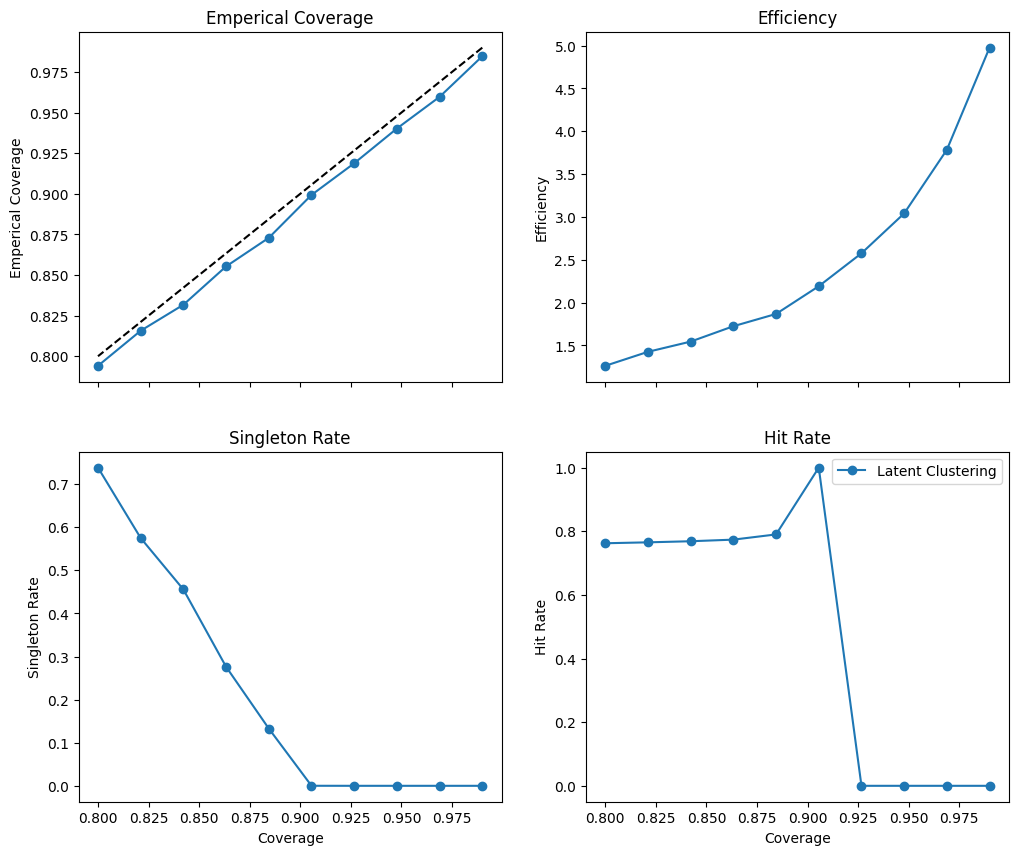

In [64]:
# Convert list of arrays to a single array
def stack_outputs(output_list):
    return np.concatenate(output_list, axis=0)

cal_latents = stack_outputs(holdout_results["latents"])
val_latents = stack_outputs(val_results["latents"])

pca = PCA(n_components=2)

latents_pca = pca.fit_transform(cal_latents)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


kmeans = KMeans(n_clusters=10, random_state=0).fit(latents_pca)
cluster_centers = kmeans.cluster_centers_
cal_cluster_ids = kmeans.predict(latents_pca)
val_cluster_ids = kmeans.predict(pca.transform(val_latents))


# # Plot the PCA-reduced latents with cluster assignments
# plt.figure(figsize=(8,6))
# plt.scatter(latents_pca[:, 0], latents_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=5)
# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='X')
# plt.title("KMeans Clustering of Latents (PCA Reduced)")
# plt.show()

daps = cp.DAPS(lam_reg=60, k_reg=0, beta=0.1, alpha = 0.1)

# Plot effect of alpha on DAPS with latent clustering
results = {"Emperical coverage": [], "Efficiency": [], "singleton_rate": [], "hit_rate": []}

for alpha in alphas:
    daps.alpha = alpha
    daps.fit(cal_outputs, cal_labels, cal_cluster_ids)
    preds = daps.predict(val_outputs, val_cluster_ids)
    metrics = cp.ConformalMetrics(preds, val_labels)
    results["Emperical coverage"].append(metrics["Coverage"])
    results["Efficiency"].append(metrics["Avg Set Size"])
    results["singleton_rate"].append(metrics["Singleton Rate"])
    results["hit_rate"].append(metrics["Singleton Hit"])
fig, ax = plt.subplots(2,2, figsize=(12,10), sharex=True)
for i, metric in enumerate(["Emperical coverage", "Efficiency", "singleton_rate", "hit_rate"]):
    ax[i//2, i % 2].plot(1-alphas, results[metric], label=f"Latent Clustering", marker='o')
    if metric == "Emperical coverage":
        ax[i//2, i % 2].plot(1-alphas, 1 - alphas, 'k--', label="Ideal Coverage")
    if i >= 2:
        ax[i//2, i % 2].set_xlabel("Coverage")
    ax[i//2, i % 2].set_ylabel(metric.replace("_", " ").title())
    ax[i//2, i % 2].set_title(f"{metric.replace('_', ' ').title()}")
plt.legend()
plt.show()